<a href="https://colab.research.google.com/github/aysimadeniz/AI-Object-Detection/blob/main/case_study_ipynbAysCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-024-08370-4/MediaObjects/41586_2024_8370_MOESM3_ESM.zip

--2025-12-17 12:24:23--  https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-024-08370-4/MediaObjects/41586_2024_8370_MOESM3_ESM.zip
Resolving static-content.springer.com (static-content.springer.com)... 151.101.0.95, 151.101.64.95, 151.101.128.95, ...
Connecting to static-content.springer.com (static-content.springer.com)|151.101.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89305224 (85M) [application/octet-stream]
Saving to: ‘41586_2024_8370_MOESM3_ESM.zip’

41586_2024_8370_MOE 100%[===================>]  85.17M   267MB/s    in 0.3s    

2025-12-17 12:24:24 (267 MB/s) - ‘41586_2024_8370_MOESM3_ESM.zip’ saved [89305224/89305224]



In [ ]:

!unzip *.zip

Archive:  41586_2024_8370_MOESM3_ESM.zip
  inflating: 2024-04-08512B-s3/SupplementaryTable1.txt  
  inflating: 2024-04-08512B-s3/SupplementaryTable2.txt  
  inflating: 2024-04-08512B-s3/SupplementaryTable3.txt  
  inflating: 2024-04-08512B-s3/SupplementaryTable4.txt  
  inflating: 2024-04-08512B-s3/SupplementaryTable5.txt  


In [ ]:
!mv *s3/* sample_data

In [ ]:
!ls sample_data

anscombe.json		      mnist_train_small.csv    SupplementaryTable3.txt
california_housing_test.csv   README.md		       SupplementaryTable4.txt
california_housing_train.csv  SupplementaryTable1.txt  SupplementaryTable5.txt
mnist_test.csv		      SupplementaryTable2.txt


In [ ]:
import polars as pl #pandasın daha modern ve hızlı versiyonu
from pathlib import Path #dosyanın okunmasını düzeltir.
import seaborn as sns #grafik çizme kütüphanesi
import matplotlib.pyplot as plt #grafik
from plotnine import * #R için bi araç
from transformers import AutoTokenizer, AutoModel #Protein dil modelini burdan alıcaz.
import torch #Derin öğrenme altyapısı
import h5py #Hierarchical Data Format veri seti büyük onu okumsk için güzel
from tqdm.autonotebook import tqdm #tqdm ile: "İşlem %35 tamamlandı, kalan süre: 12 dakika" yazar. Kod çalışırken ekran bozuldu mu vs diye korkmamak için
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit #veryi rastgele karıştırır, eğitim test diye böler.GroupShuffleSplit ise çok önemli veriyi bölerken proteinleri parçalamamak için kullanılır
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler #Tüm verileri aynı ölçeğe getirir.
from sklearn.decomposition import PCA #boyut indirgeme
from sklearn.metrics import mean_squared_error, r2_score
import torch #PyTorch kütüphanesindendir

In [ ]:
df = pl.read_csv('/content/sample_data/SupplementaryTable5.txt', separator='\t', null_values='NA')
df

domain_ID,uniprot_ID,uniprot_ID_mutation,aa_seq,fitness,fitness_sigma,scaled_fitness,scaled_fitness_sigma,ESM1v_domain,RaSP,ddmut,FoldX,popEVE,EVE,Tranception,EVE_domain,rsasa,thermoMPNN,AlphaMissense,ESM1v_full-length,Organism,Gene Names (primary),Gene Names (synonym)
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,f64,str,str,str,str
"""A0A2R8Y422_PF00240_2""","""A0A2R8Y422""","""A0A2R8Y422_A28*""","""QIFVKTLMGKTITLEVELSDTIDNVK*KIQ…",0.059234,0.009105,-0.422846,0.1275171,null,null,null,null,null,null,null,null,41.3,null,null,null,"""Homo sapiens (Human)""",null,null
"""A0A2R8Y422_PF00240_2""","""A0A2R8Y422""","""A0A2R8Y422_A28C""","""QIFVKTLMGKTITLEVELSDTIDNVKCKIQ…",0.091262,0.003764,0.0257376,0.052712,-9.862297,0.944872,-0.14,0.865303,null,null,null,4.980072,41.3,-0.120494,0.334,null,"""Homo sapiens (Human)""",null,null
"""A0A2R8Y422_PF00240_2""","""A0A2R8Y422""","""A0A2R8Y422_A28D""","""QIFVKTLMGKTITLEVELSDTIDNVKDKIQ…",0.097388,0.003962,0.1115442,0.055491,-8.525545,0.344768,-0.01,0.975219,null,null,null,3.7665176,41.3,0.842978,0.279,null,"""Homo sapiens (Human)""",null,null
"""A0A2R8Y422_PF00240_2""","""A0A2R8Y422""","""A0A2R8Y422_A28E""","""QIFVKTLMGKTITLEVELSDTIDNVKEKIQ…",0.1101532,0.007189,0.2903249,0.1006934,-7.011676,-0.044519,0.05,0.703796,null,null,null,2.854782,41.3,0.355797,0.2014,null,"""Homo sapiens (Human)""",null,null
"""A0A2R8Y422_PF00240_2""","""A0A2R8Y422""","""A0A2R8Y422_A28F""","""QIFVKTLMGKTITLEVELSDTIDNVKFKIQ…",0.089583,0.003577,0.002225,0.050106,-10.680157,-0.423373,-0.44,0.0618476,null,null,null,5.208206,41.3,0.118878,0.3648,null,"""Homo sapiens (Human)""",null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q9Y6V0_PF05715_1058""","""Q9Y6V0""","""Q9Y6V0_W1104S""","""TCPLCKTELNIGSKDPPNFNTCTECKNQVC…",0.1054545,0.012201,-0.029589,0.137867,-5.345161,5.397289,-1.88,2.23219,null,null,null,8.343338,11.8,2.117514,0.9588,"""-12.64865""","""Homo sapiens (Human)""","""PCLO""","""ACZ KIAA0559"""
"""Q9Y6V0_PF05715_1058""","""Q9Y6V0""","""Q9Y6V0_W1104T""","""TCPLCKTELNIGSKDPPNFNTCTECKNQVC…",0.090854,0.015305,-0.194564,0.1729378,-5.214868,4.558003,-1.69,1.77879,null,null,null,9.494637,11.8,1.988062,0.9647,"""-14.00641""","""Homo sapiens (Human)""","""PCLO""","""ACZ KIAA0559"""
"""Q9Y6V0_PF05715_1058""","""Q9Y6V0""","""Q9Y6V0_W1104V""","""TCPLCKTELNIGSKDPPNFNTCTECKNQVC…",0.1158156,0.010449,0.087485,0.1180705,-4.870904,3.148088,-1.42,1.52182,null,null,null,8.973549,11.8,1.270481,0.9512,"""-13.55418""","""Homo sapiens (Human)""","""PCLO""","""ACZ KIAA0559"""


In [ ]:
import os

print("--- 1. Ana Klasördeki Dosyalar ---")
print(os.listdir('/content/'))

print("\n--- 2. sample_data Klasöründeki Dosyalar ---")
try:
    print(os.listdir('/content/sample_data/'))
except:
    print("sample_data klasörü bile yok!")

# Dosyayı isminden arayalım
print("\n--- 3. Arama Sonucu ---")
bulundu = False
for root, dirs, files in os.walk("/content/"):
    for file in files:
        if "Table5" in file or "txt" in file:
            print(f"BULDUM! Dosya burada: {os.path.join(root, file)}")
            bulundu = True

if not bulundu:
    print("❌ Dosya hiçbir yerde yok. Silinmiş.")

--- 1. Ana Klasördeki Dosyalar ---
['.config', '41586_2024_8370_MOESM3_ESM.zip', '2024-04-08512B-s3', 'sample_data']

--- 2. sample_data Klasöründeki Dosyalar ---
['README.md', 'anscombe.json', 'SupplementaryTable4.txt', 'SupplementaryTable2.txt', 'SupplementaryTable5.txt', 'SupplementaryTable1.txt', 'SupplementaryTable3.txt', 'mnist_train_small.csv', 'mnist_test.csv', 'california_housing_train.csv', 'california_housing_test.csv']

--- 3. Arama Sonucu ---
BULDUM! Dosya burada: /content/2024-04-08512B-s3/SupplementaryTable4.txt
BULDUM! Dosya burada: /content/2024-04-08512B-s3/SupplementaryTable2.txt
BULDUM! Dosya burada: /content/2024-04-08512B-s3/SupplementaryTable1.txt
BULDUM! Dosya burada: /content/2024-04-08512B-s3/SupplementaryTable3.txt
BULDUM! Dosya burada: /content/sample_data/SupplementaryTable4.txt
BULDUM! Dosya burada: /content/sample_data/SupplementaryTable2.txt
BULDUM! Dosya burada: /content/sample_data/SupplementaryTable5.txt
BULDUM! Dosya burada: /content/sample_data/Supp

In [ ]:
import os
import shutil

print("📦 Zip dosyası açılıyor... (Biraz bekletebilir)")
# Zip dosyasını aç (sessiz modda)
os.system("unzip -o 41586_2024_8370_MOESM3_ESM.zip > /dev/null")

print("🕵️ Dosya aranıyor ve yerine taşınıyor...")

# Dosyayı bulup sample_data içine taşıyacak akıllı döngü
hedef_yol = "/content/sample_data/SupplementaryTable5.txt"
bulundu = False

for root, dirs, files in os.walk("/content/"):
    for file in files:
        # Dosya isminin bir parçası eşleşiyorsa yakala
        if "Table5" in file and file.endswith(".txt"):
            kaynak = os.path.join(root, file)

            # Eğer dosya zaten doğru yerdeyse taşıma
            if kaynak != hedef_yol:
                shutil.move(kaynak, hedef_yol)
                print(f"✅ BAŞARILI! Dosya bulundu ve şuraya taşındı: {hedef_yol}")
            else:
                print(f"✅ Dosya zaten doğru yerde: {hedef_yol}")

            bulundu = True
            break
    if bulundu: break

if not bulundu:
    print("❌ Hata: Zip açıldı ama içinden 'Table5' dosyası çıkmadı.")
else:
    print("-" * 40)
    print("🚀 SORUN ÇÖZÜLDÜ! Şimdi 'df = pl.read_csv...' kodunu tekrar çalıştırabilirsin.")

📦 Zip dosyası açılıyor... (Biraz bekletebilir)
🕵️ Dosya aranıyor ve yerine taşınıyor...
✅ BAŞARILI! Dosya bulundu ve şuraya taşındı: /content/sample_data/SupplementaryTable5.txt
----------------------------------------
🚀 SORUN ÇÖZÜLDÜ! Şimdi 'df = pl.read_csv...' kodunu tekrar çalıştırabilirsin.


In [ ]:
df.columns

['domain_ID',
 'uniprot_ID',
 'uniprot_ID_mutation',
 'aa_seq',
 'fitness',
 'fitness_sigma',
 'scaled_fitness',
 'scaled_fitness_sigma',
 'ESM1v_domain',
 'RaSP',
 'ddmut',
 'FoldX',
 'popEVE',
 'EVE',
 'Tranception',
 'EVE_domain',
 'rsasa',
 'thermoMPNN',
 'AlphaMissense',
 'ESM1v_full-length',
 'Organism',
 'Gene Names (primary)',
 'Gene Names (synonym)']

In [ ]:
df.head().select('Organism')

Organism
str
"""Homo sapiens (Human)"""
"""Homo sapiens (Human)"""
"""Homo sapiens (Human)"""
"""Homo sapiens (Human)"""
"""Homo sapiens (Human)"""


In [ ]:
# df_subset = df.filter(pl.col('Organism') == "Homo sapiens (Human)").select(['domain_ID', 'uniprot_ID', 'uniprot_ID_mutation', 'aa_seq', 'fitness'])

df_subset = (
    df
    .filter(pl.col('Organism') == "Homo sapiens (Human)") #sadece insan olan verileri seçiyoruz
    .filter(~pl.col('aa_seq').str.contains('\*')) #yarım kalan proteinleri at
    .select(['domain_ID', 'uniprot_ID', 'uniprot_ID_mutation', 'aa_seq', 'scaled_fitness']) #yazan sütunları tut.
  )

<>:6: SyntaxWarning: invalid escape sequence '\*'
<>:6: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipython-input-1517306196.py:6: SyntaxWarning: invalid escape sequence '\*'


In [ ]:

df = df.filter(~pl.col('aa_seq').str.contains(r'\*'))

print(f"✅ Temizlik Tamam! Kalan satır sayısı: {len(df)}")

✅ Temizlik Tamam! Kalan satır sayısı: 576963


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd


In [ ]:
df = pl.read_csv('/content/sample_data/SupplementaryTable5.txt', separator='\t', null_values='NA')

(Yıldız) * işareti biyolojide Stop Kodon demektir. Yani protein üretilirken bir mutasyon olmuş ve proteinin yarısı üretilmeden üretim durmuş (Nonsense Mutation).

Bizim projemiz ise Missense (Tek harf değişimi ama proteinin tamamı üretiliyor) üzerine.

 ~ işareti "Tersini al" demek. Yani: İçinde yıldız işareti OLANLARI ALMA, sağlam olanları al.

--- Benchmark Analysis Starting ---

✅ FOUND COLUMN: AlphaMissense
📊 Spearman Correlation: -0.324


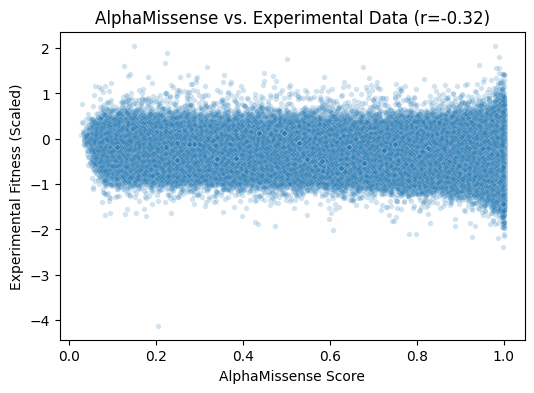


✅ FOUND COLUMN: ESM1v_domain
📊 Spearman Correlation: 0.360


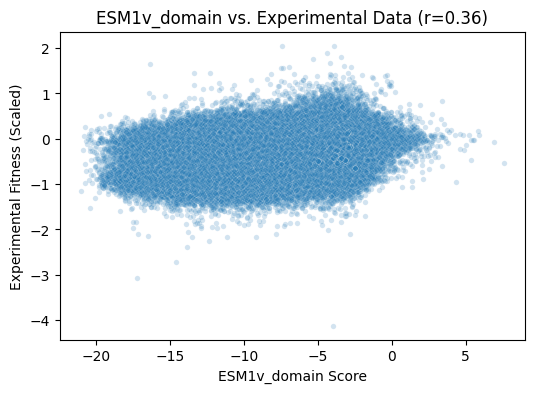


✅ FOUND COLUMN: EVE_domain
📊 Spearman Correlation: -0.423


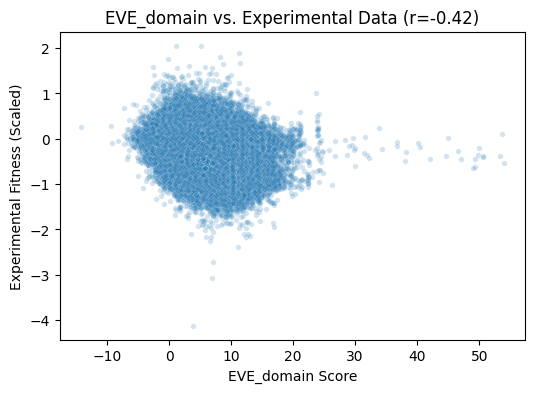


✅ FOUND COLUMN: ESM1v_domain
📊 Spearman Correlation: 0.360


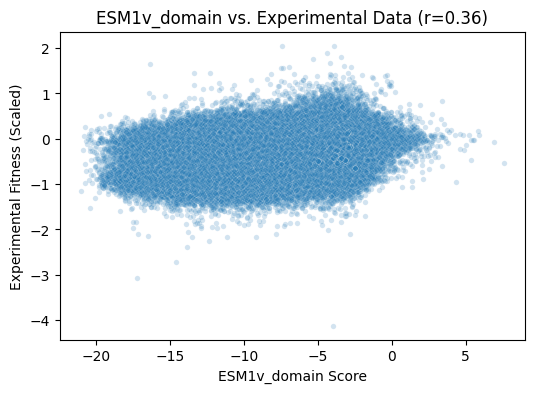


✅ FOUND COLUMN: ESM1v_full-length
📊 Spearman Correlation: 0.120


In [ ]:
# 1. Convert Polars DataFrame to Pandas for easier analysis & plotting
# (The original dataframe 'df' is in Polars format)
pandas_df = df.to_pandas()

print("--- Benchmark Analysis Starting ---")

# Target Variable (Ground Truth from the Experiment)
target = 'scaled_fitness'

# Competitor Models / Scores to Check
# We look for partial matches (e.g., if column is named 'AlphaMissense_score', it will be found)
predictors_to_check = ['AlphaMissense', 'ESM1v_domain', 'EVE_domain', 'ESM1v', 'score']

found_predictor = False

for predictor in predictors_to_check:
    # Find columns that contain the predictor keyword
    matching_columns = [col for col in pandas_df.columns if predictor in col]

    for col_name in matching_columns:
        # Avoid calculating correlation with the target itself or non-numeric columns
        if col_name == target:
            continue

        found_predictor = True

        # Drop missing values (NaN) for accurate correlation calculation
        temp_data = pandas_df[[target, col_name]].dropna()

        if len(temp_data) > 0:
            # Calculate Spearman Correlation
            corr, p_val = spearmanr(temp_data[target], temp_data[col_name])

            # PRINT RESULTS
            print(f"\n✅ FOUND COLUMN: {col_name}")
            print(f"📊 Spearman Correlation: {corr:.3f}")

            # PLOT GRAPH
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=temp_data[col_name], y=temp_data[target], alpha=0.2, s=15)
            plt.title(f'{col_name} vs. Experimental Data (r={corr:.2f})')
            plt.xlabel(f'{col_name} Score')
            plt.ylabel('Experimental Fitness (Scaled)')
            plt.show()

if not found_predictor:
    print("\n⚠️ WARNING: Predictor columns (like AlphaMissense or ESM1v) were NOT FOUND in this dataframe.")
    print("Action Required: We need to load the separate predictions file and merge it with the experimental data.")

Tüm modeller için hesaplama yapılıyor...
✅ Hesaplama Bitti! 434 protein analiz edildi.


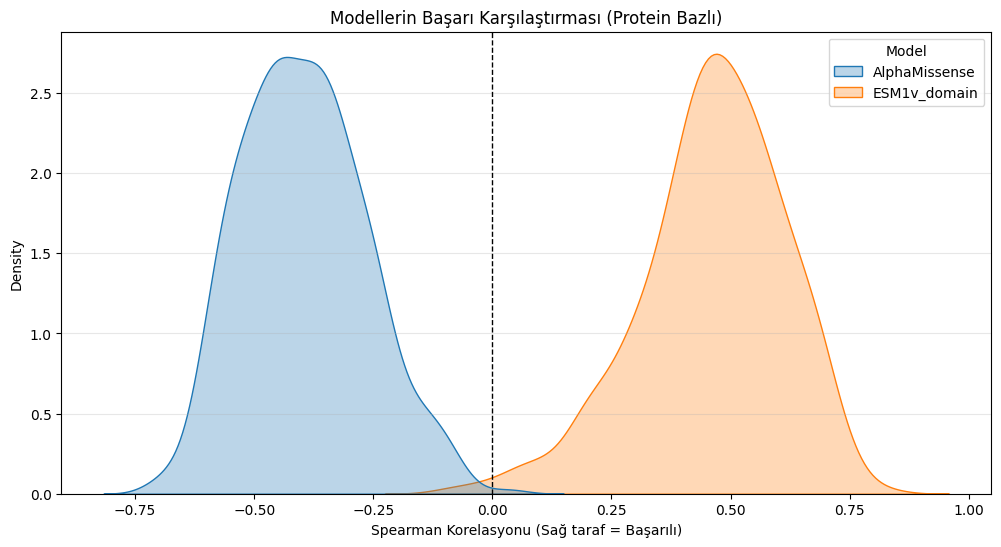

Medyan Korelasyonlar:
AlphaMissense   -0.401254
ESM1v_domain     0.470736
dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

print("Tüm modeller için hesaplama yapılıyor...")

# 1. POLARS İLE TOPLU HESAPLAMA
# Tek seferde AlphaMissense, ESM1v ve EVE için korelasyon alıyoruz
df_per_protein = (
    df.group_by("uniprot_ID")
    .agg([
        pl.corr("scaled_fitness", "AlphaMissense", method="spearman").alias("AlphaMissense"),
        pl.corr("scaled_fitness", "ESM1v_domain", method="spearman").alias("ESM1v_domain"),
        # Eğer EVE sütunu varsa şu satırın başındaki # işaretini kaldır:
        # pl.corr("scaled_fitness", "EVE", method="spearman").alias("EVE"),
        pl.len().alias("count")
    ])
    .filter(pl.col("count") > 10) # 10'dan az verisi olanları at
)

# 2. PANDAS'A ÇEVİR (Grafik İçin)
df_plot = df_per_protein.to_pandas()

# Veriyi "Uzun" formata çeviriyoruz ki Seaborn renkli çizebilsin
df_melted = df_plot.melt(id_vars=["uniprot_ID", "count"],
                         value_vars=["AlphaMissense", "ESM1v_domain"], # EVE varsa buraya "EVE" ekle
                         var_name="Model",
                         value_name="Correlation")

print(f"✅ Hesaplama Bitti! {len(df_plot)} protein analiz edildi.")

# 3. KARŞILAŞTIRMALI GRAFİK
plt.figure(figsize=(12, 6))

# KDE Plot (Yoğunluk Eğrisi) - Daha profesyonel görünür
sns.kdeplot(data=df_melted, x="Correlation", hue="Model", fill=True, alpha=0.3, common_norm=False)

plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title('Modellerin Başarı Karşılaştırması (Protein Bazlı)')
plt.xlabel('Spearman Korelasyonu (Sağ taraf = Başarılı)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# İstatistikleri Yazdır
print("Medyan Korelasyonlar:")
print(df_plot[["AlphaMissense", "ESM1v_domain"]].median())

Analiz edilecek modeller: ['AlphaMissense', 'ESM1v_domain', 'EVE_domain', 'EVE']


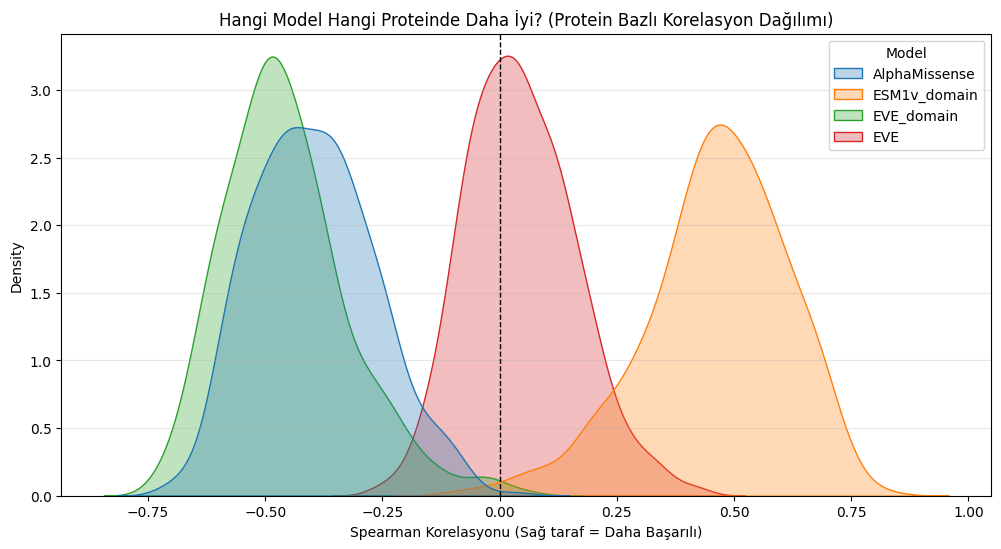


--- Modellerin Medyan (Ortanca) Başarısı ---
AlphaMissense   -0.401254
ESM1v_domain     0.470736
EVE_domain      -0.472208
EVE              0.036914
dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

# Olası model isimleri (Veri setindeki isimlerine göre burayı düzeltebilirsin)
# "ESM2" genelde embedding modelidir, skor sütunu "ESM1v_domain" olabilir.
potential_models = ["AlphaMissense", "ESM1v_domain", "EVE_domain", "EVE"]

# Veri setinde hangileri varsa onları otomatik seçiyoruz
available_models = [col for col in potential_models if col in df.columns]

print(f"Analiz edilecek modeller: {available_models}")

# 1. POLARS İLE HESAPLAMA (Tüm modeller için döngü)
# Dinamik olarak her model için korelasyon hesaplayan ifadeyi oluşturuyoruz
agg_exprs = [pl.corr("scaled_fitness", model, method="spearman").alias(model) for model in available_models]
agg_exprs.append(pl.len().alias("count")) # Veri sayısını da ekle

df_per_protein = (
    df.group_by("uniprot_ID")
    .agg(agg_exprs)
    .filter(pl.col("count") > 10) # 10'dan az mutasyonu olan proteinleri at
)

# 2. GRAFİK İÇİN PANDAS'A ÇEVİR VE DÜZENLE
df_plot = df_per_protein.to_pandas()

# "Wide" formattan "Long" formata çeviriyoruz (Seaborn çizimi için gerekli)
df_melted = df_plot.melt(
    id_vars=["uniprot_ID", "count"],
    value_vars=available_models,
    var_name="Model",
    value_name="Correlation"
)

# 3. KARŞILAŞTIRMALI KDE GRAFİĞİ
plt.figure(figsize=(12, 6))

# KDE Plot (Yoğunluk Eğrisi) - Modellerin dağılımını üst üste gösterir
sns.kdeplot(data=df_melted, x="Correlation", hue="Model", fill=True, alpha=0.3, common_norm=False, palette="tab10")

plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title('Hangi Model Hangi Proteinde Daha İyi? (Protein Bazlı Korelasyon Dağılımı)')
plt.xlabel('Spearman Korelasyonu (Sağ taraf = Daha Başarılı)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# 4. SONUÇLARI YAZDIR (MEDYAN)
print("\n--- Modellerin Medyan (Ortanca) Başarısı ---")
print(df_plot[available_models].median())

/tmp/ipython-input-3981230436.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



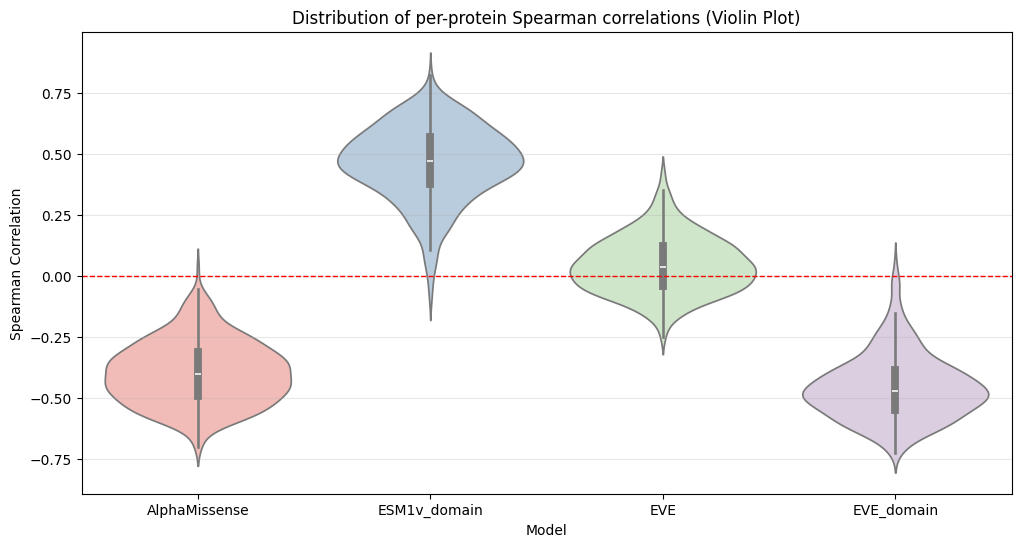

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

# --- ÖNCE HESAPLAMA (Veri hazırsa burayı geçebilirsin) ---
potential_models = ["AlphaMissense", "ESM1v_domain", "EVE", "EVE_domain"]
available_models = [col for col in potential_models if col in df.columns]

# Protein bazlı hesaplama
df_per_protein = (
    df.group_by("uniprot_ID")
    .agg([pl.corr("scaled_fitness", m, method="spearman").alias(m) for m in available_models] + [pl.len().alias("count")])
    .filter(pl.col("count") > 10)
)
df_plot = df_per_protein.to_pandas()
df_melted = df_plot.melt(id_vars=["uniprot_ID", "count"], value_vars=available_models, var_name="Model", value_name="Correlation")

# --- İŞTE ONLARIN GRAFİĞİ (VIOLIN PLOT) ---
plt.figure(figsize=(12, 6))

# "Violinplot" fonksiyonunu kullanıyoruz
sns.violinplot(data=df_melted, x="Model", y="Correlation", palette="Pastel1", inner="box")

plt.axhline(y=0, color='red', linestyle='--', linewidth=1) # Sıfır çizgisi
plt.title('Distribution of per-protein Spearman correlations (Violin Plot)')
plt.ylabel('Spearman Correlation')
plt.grid(axis='y', alpha=0.3)
plt.show()

## Run ESM-2

In [ ]:
esm2_model_path = 'facebook/esm2_t33_650M_UR50D'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# seq_df = df_subset.drop_nans().drop_nulls().head(1000) \
#   .with_columns(pl.col('aa_seq').str.replace('\*', '')) \
#   .select(['uniprot_ID_mutation', 'aa_seq', 'scaled_fitness']) \
#   .unique('uniprot_ID_mutation')

seq_df = (
    df_subset
    .drop_nans().drop_nulls()
    .sample(n=10_000, seed=7)
    # .with_columns(pl.col('aa_seq').str.replace('\*', ''))
    .select(['uniprot_ID_mutation', 'aa_seq', 'scaled_fitness'])
    .unique('uniprot_ID_mutation')
)

In [ ]:
seq_df.with_columns(plen=pl.col('aa_seq').str.len_chars()).sort('plen', descending=True).head()

uniprot_ID_mutation,aa_seq,scaled_fitness,plen
str,str,f64,u32
"""Q14160_S882C""","""LRQRHVACLARSERGLGFSIAGGKGCTPYR…",-0.001159,97
"""Q14160_Q910K""","""LRQRHVACLARSERGLGFSIAGGKGSTPYR…",0.086105,97
"""Q14160_R870C""","""LRQRHVACLARSECGLGFSIAGGKGSTPYR…",-0.16254,97
"""Q14160_L945R""","""LRQRHVACLARSERGLGFSIAGGKGSTPYR…",-0.281444,97
"""Q14160_P940C""","""LRQRHVACLARSERGLGFSIAGGKGSTPYR…",-0.32661,97


In [ ]:
inputs = tokenizer(list(seq_df['aa_seq']), return_tensors="pt", padding=True, truncation=True, max_length=300)

In [ ]:
model = AutoModel.from_pretrained(esm2_model_path)

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
model

EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 1280, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-32): 33 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=1280, out_features=1280, bias=True)
            (key): Linear(in_features=1280, out_features=1280, bias=True)
            (value): Linear(in_features=1280, out_features=1280, bias=True)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=1280, out_features=1280, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=1280, out_features=5120, bias=True)
        )
        (output): EsmOut

In [ ]:
torch.cuda.empty_cache()
batch_size=1000
res_dict = {}
fitness_list = []
for i in tqdm(range(0, len(inputs["input_ids"]), batch_size)):
    batch_input_ids = inputs['input_ids'][i:i+batch_size].to(device)
    batch_seq_ids = seq_df[i:i+batch_size]['uniprot_ID_mutation'].to_list()
    # batch_fitness = seq_df[i:i+batch_size]['fitness'].to_list()
    batch_fitness = seq_df[i:i+batch_size]['scaled_fitness'].to_list()
    batch_attention_mask = inputs['attention_mask'][i:i+batch_size].to(device)
    with torch.no_grad():
        with torch.autocast('cuda'):
            output = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)['last_hidden_state'].float()
            # iterate over batch elements
            for j in range(output.shape[0]):
                embedding = output[j][batch_attention_mask[j].bool(), :].detach().half().cpu()
                averaged = embedding.mean(axis=0)
                res_dict[batch_seq_ids[j]] = averaged.numpy()
                fitness_list.append(batch_fitness[j])

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
groups = np.array([k.split('_')[0] for k in res_dict.keys()])

In [ ]:
X = np.vstack(list(res_dict.values()))

In [ ]:
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
n_components_to_keep = 50
pca = PCA(n_components=n_components_to_keep)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
y = np.array(fitness_list)

In [ ]:
X.shape

(9995, 1280)

In [ ]:
y.shape

(9995,)

In [ ]:
groups.shape

(9995,)

In [ ]:
np.unique(groups)

array(['A0A2R8Y422', 'A0PJY2', 'A1X283', 'A2RRE5', 'A6NK59', 'O00308',
       'O00330', 'O14529', 'O14640', 'O14776', 'O14813', 'O14901',
       'O14936', 'O15151', 'O15259', 'O15265', 'O15266', 'O15344',
       'O15350', 'O15405', 'O15541', 'O43167', 'O43186', 'O43295',
       'O43353', 'O43374', 'O43395', 'O43586', 'O60281', 'O60293',
       'O60341', 'O60481', 'O60885', 'O75112', 'O75360', 'O75366',
       'O75369', 'O75382', 'O75400', 'O75478', 'O75534', 'O75554',
       'O75808', 'O75953', 'O75970', 'O94830', 'O94885', 'O94929',
       'O94993', 'O95076', 'O95155', 'O95218', 'O95267', 'O95343',
       'O95409', 'O95475', 'O95714', 'O95718', 'O95789', 'O95793',
       'O95817', 'O95835', 'P00519', 'P02549', 'P02585', 'P04049',
       'P04150', 'P05813', 'P06239', 'P06241', 'P07315', 'P07316',
       'P07320', 'P07814', 'P08151', 'P08235', 'P08631', 'P09086',
       'P09327', 'P0CI26', 'P10070', 'P10071', 'P10242', 'P10275',
       'P10398', 'P10589', 'P10826', 'P11182', 'P11308', '

<Axes: ylabel='Count'>

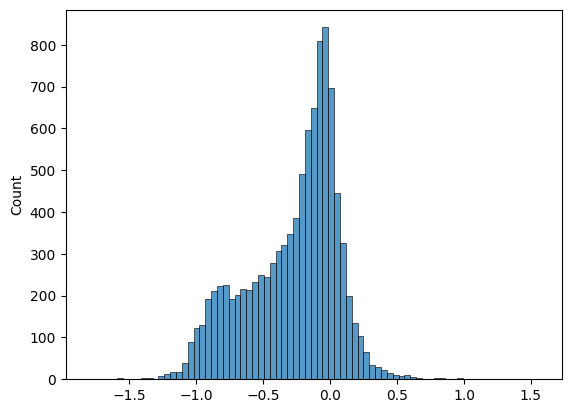

In [ ]:
sns.histplot(y)

# Ridge regression

## Split across proteins

In [ ]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
# gss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


# Get the indices for the single split
# 'gss.split()' returns an iterator, we immediately take the first (and only) item.
train_idx, test_idx = next(gss.split(X, y, groups=groups))

In [ ]:
np.unique(groups[test_idx])

array(['A0A2R8Y422', 'A2RRE5', 'O00308', 'O14776', 'O15265', 'O15266',
       'O15344', 'O15350', 'O15405', 'O43186', 'O43353', 'O43374',
       'O60341', 'O60481', 'O75112', 'O75478', 'O75808', 'O94830',
       'O94885', 'O95475', 'O95714', 'O95718', 'O95817', 'P04150',
       'P07315', 'P07320', 'P07814', 'P08631', 'P09086', 'P09327',
       'P0CI26', 'P10242', 'P10398', 'P12081', 'P13796', 'P13984',
       'P17480', 'P20936', 'P22914', 'P25685', 'P35711', 'P35713',
       'P48431', 'P49335', 'P51508', 'P54277', 'P55072', 'P61960',
       'P67809', 'Q00987', 'Q03181', 'Q12830', 'Q13368', 'Q13424',
       'Q13472', 'Q14839', 'Q14CM0', 'Q15475', 'Q5F1R6', 'Q5VWI1',
       'Q68DC2', 'Q6NWY9', 'Q7Z5Q1', 'Q7Z6W7', 'Q86VP1', 'Q86XK2',
       'Q8IX12', 'Q8IYH5', 'Q8IZT6', 'Q8ND56', 'Q8NEA6', 'Q8TAT5',
       'Q8TEW0', 'Q8WXI2', 'Q8WXI9', 'Q96GE6', 'Q96J02', 'Q96QS3',
       'Q96T51', 'Q9H2P0', 'Q9H347', 'Q9H3Z4', 'Q9H7E2', 'Q9H9L4',
       'Q9HAZ2', 'Q9HC78', 'Q9NSC2', 'Q9NU63', 'Q9NW38', '

In [ ]:
np.unique(groups[train_idx])

array(['A0PJY2', 'A1X283', 'A6NK59', 'O00330', 'O14529', 'O14640',
       'O14813', 'O14901', 'O14936', 'O15151', 'O15259', 'O15541',
       'O43167', 'O43295', 'O43395', 'O43586', 'O60281', 'O60293',
       'O60885', 'O75360', 'O75366', 'O75369', 'O75382', 'O75400',
       'O75534', 'O75554', 'O75953', 'O75970', 'O94929', 'O94993',
       'O95076', 'O95155', 'O95218', 'O95267', 'O95343', 'O95409',
       'O95789', 'O95793', 'O95835', 'P00519', 'P02549', 'P02585',
       'P04049', 'P05813', 'P06239', 'P06241', 'P07316', 'P08151',
       'P08235', 'P10070', 'P10071', 'P10275', 'P10589', 'P10826',
       'P11182', 'P11308', 'P11844', 'P12931', 'P12956', 'P14598',
       'P14653', 'P14859', 'P14921', 'P15056', 'P15498', 'P16157',
       'P16885', 'P16989', 'P19793', 'P19878', 'P20264', 'P20265',
       'P20929', 'P22492', 'P22681', 'P23759', 'P25490', 'P26367',
       'P26651', 'P28069', 'P28360', 'P32243', 'P35251', 'P35548',
       'P35712', 'P35716', 'P37275', 'P39880', 'P41002', 'P412

In [ ]:
# assert len(set(np.unique(groups[test_idx])).intersection(set(np.unique(groups[train_idx])))) == 0

In [ ]:
# Split the data using the indices

# X_train = X[train_idx]
# X_test = X[test_idx]
X_train = X_scaled[train_idx]
X_test = X_scaled[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

In [ ]:
X_train.shape

(7624, 1280)

In [ ]:
X_test.shape

(2371, 1280)

In [ ]:
# Choose the regularization strength (alpha)

# Initialize the Ridge model
# model = RidgeCV(cv=5)

alpha_value = 100.0 # Start with a moderate value, or use cross-validation to find the best one
model = Ridge(alpha=alpha_value)

# Train the model using the scaled training data
model.fit(X_train, y_train)

Ridge(alpha=100.0)

In [ ]:
y_train_pred = model.predict(X_train)
r2_score(y_train, y_train_pred)

0.36339295495442314

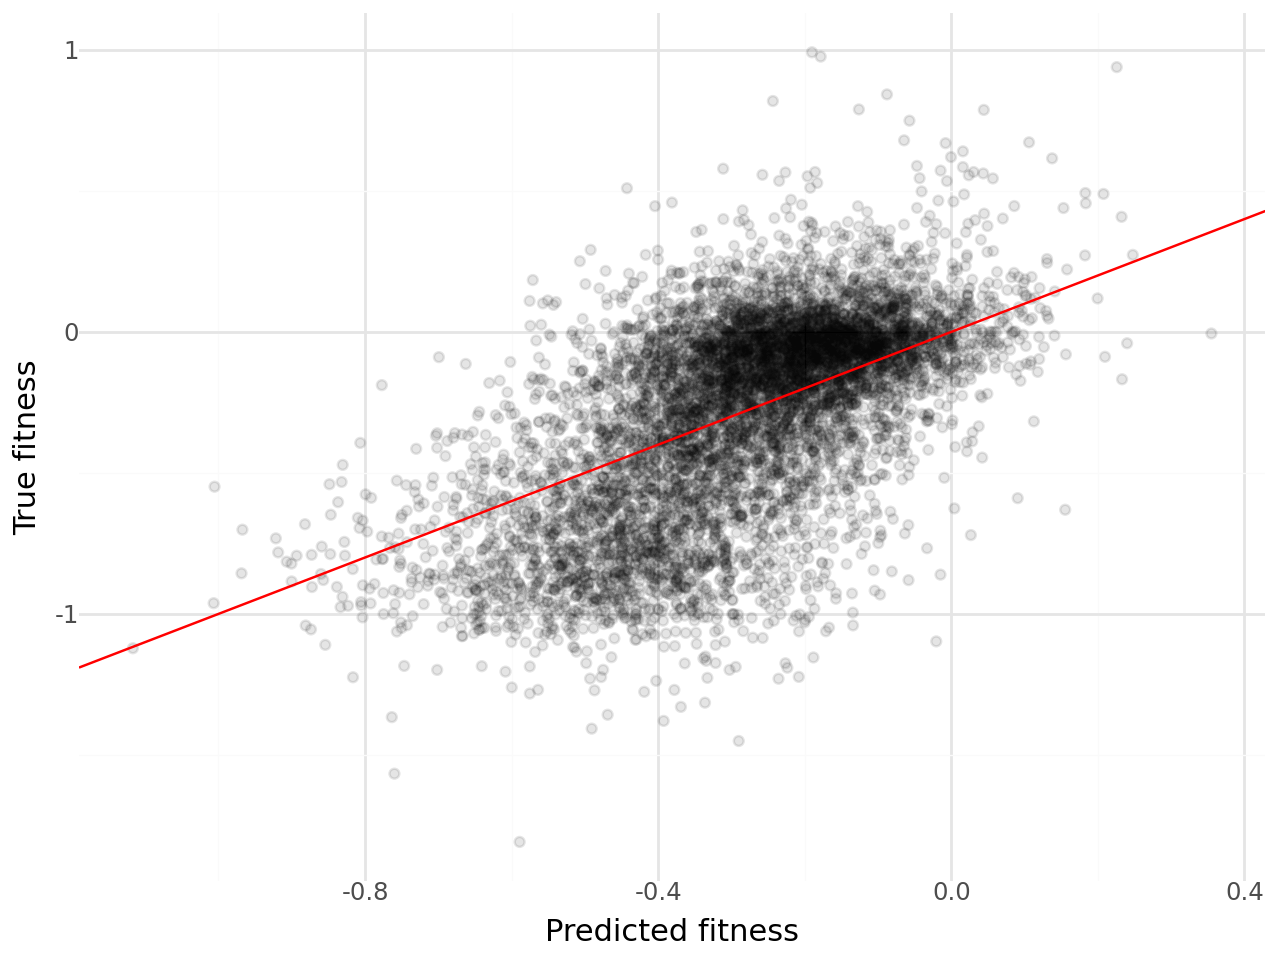

In [ ]:
(
    ggplot(pl.DataFrame({'y_train': y_train, 'y_train_pred': y_train_pred}), aes(x='y_train_pred', y='y_train'))
    + geom_point(alpha=0.1)
    + geom_abline(slope=1, intercept=0, color='red')
    + labs(x='Predicted fitness', y='True fitness')
    + theme_minimal()
)

In [ ]:
# Make predictions on the scaled test data
y_test_pred = model.predict(X_test)
r2_score(y_test, y_test_pred)

-0.7555068423844808

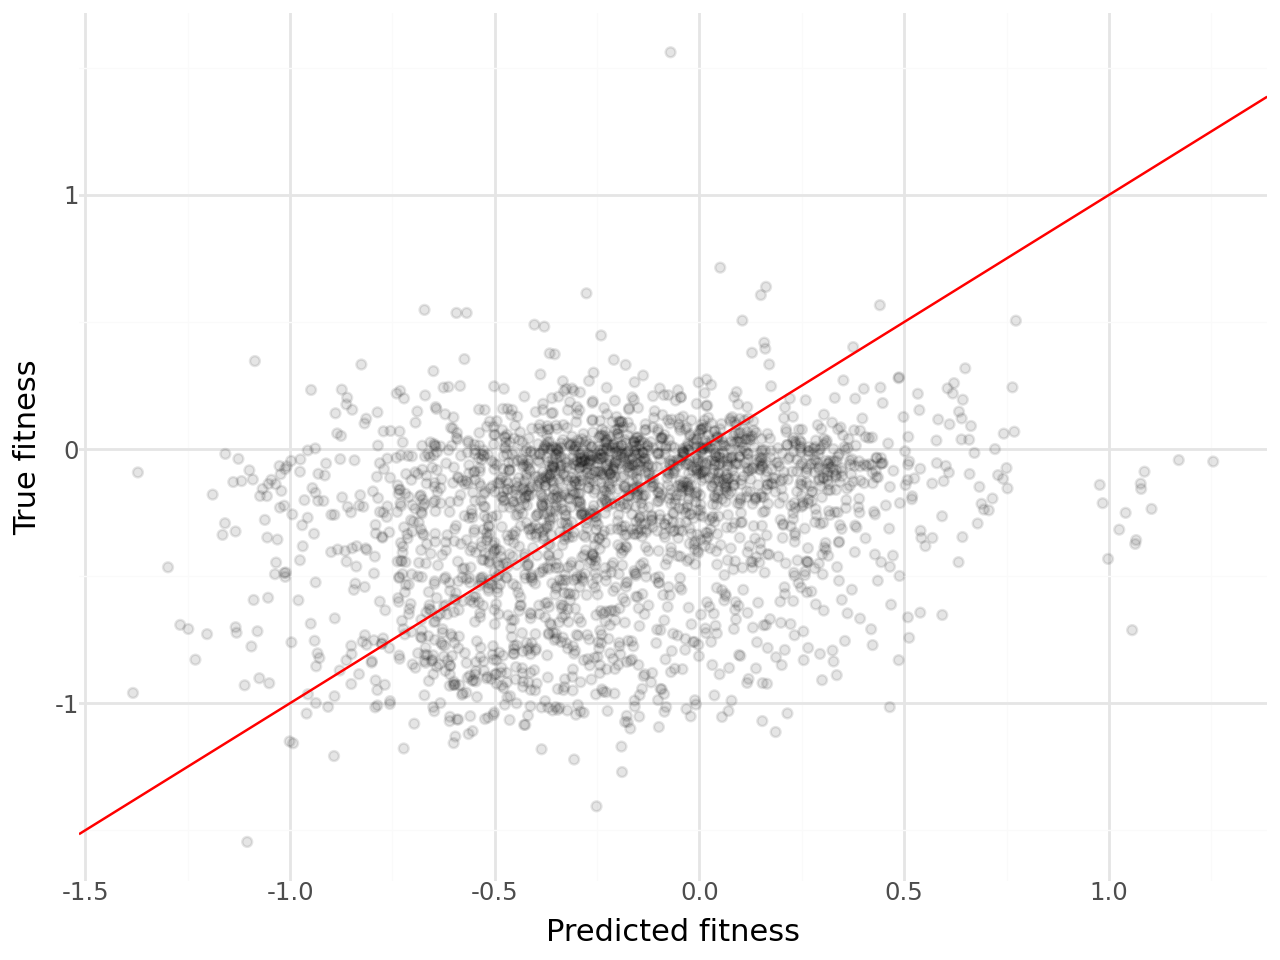

In [ ]:
(
    ggplot(pl.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred}), aes(x='y_test_pred', y='y_test'))
    + geom_point(alpha=0.1)
    + geom_abline(slope=1, intercept=0, color='red')
    + labs(x='Predicted fitness', y='True fitness')
    + theme_minimal()
)